In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import Path
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = Path('./open')
feature_dir = Path('./build/feature')
val_dir = Path('./ensemble/build/val')
tst_dir = Path('./ensemble/build/tst')
sub_dir = Path('./open/sub')
dirs = [feature_dir, val_dir, tst_dir, sub_dir]
for d in dirs:
    os.makedirs(d, exist_ok=True)

trn_file = data_dir / 'train_processed_500.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'
glove_file = './dataset/glove.6B/glove.6B.100d.txt'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [3]:
algo_name = 'dnn'
feature_name = 'glove'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [4]:
embeddings_index = {}
with open(glove_file, encoding = 'UTF8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors.')

Found 400001 word vectors.


<h2> 학습데이터 로드

In [5]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author,length
index,,,
0,He was almost choking. There was so much so mu...,3,235
1,Your sister asked for it I suppose,2,34
2,She was engaged one day as she walked in peru...,1,312
3,The captain was in the porch keeping himself c...,4,305
4,Have mercy gentlemen odin flung up his hands. ...,3,215


In [6]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


<h2> Preprocessing

In [7]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "odin",
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [8]:
train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [9]:
train['length'] = train['text'].apply(len)

In [10]:
idx_under_20 = train[train['length'] < 20].index
train = train.drop(idx_under_20)
train = train.reset_index()
train.describe()

,index,author,length
count,166641.000000,166641.000000,166641.000000
mean,92005.666649,2.045913,104.692315
std,52938.589914,1.293911,109.353860
min,0.000000,0.000000,20.000000
25%,46306.000000,1.000000,44.000000
50%,92135.000000,2.000000,72.000000
75%,137863.000000,3.000000,119.000000
max,183467.000000,4.000000,1387.000000


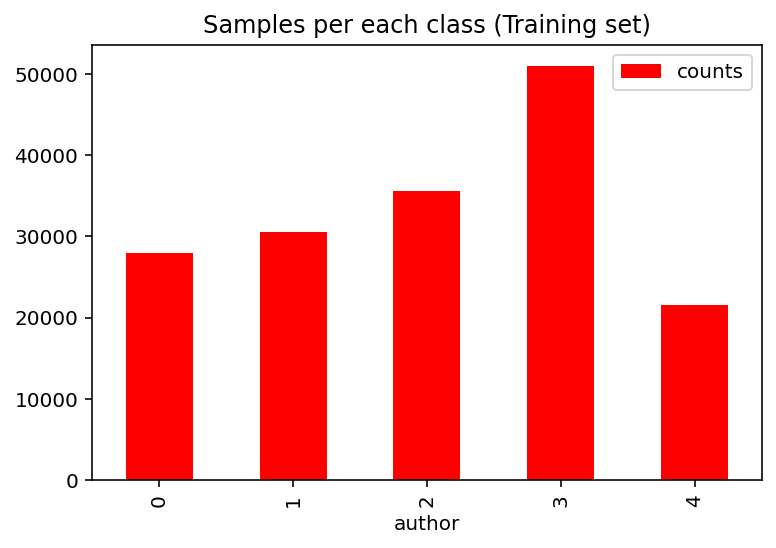

In [11]:
train.groupby(train.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')


In [12]:
train['length']= train['text'].apply(len)
train['text'].duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
166636     True
166637     True
166638     True
166639     True
166640     True
Name: text, Length: 166641, dtype: bool

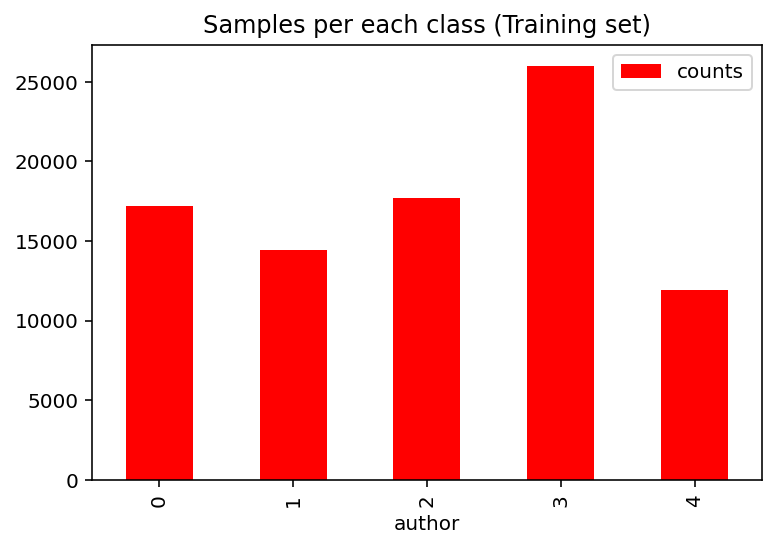

In [13]:
df = train.drop_duplicates(['text'])
df.groupby(df.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')


In [14]:
df = df.reset_index()

In [15]:
df[df['length']>500].describe()
df=df.drop(columns='level_0')

In [16]:
df['index'] = df['index'].reset_index()

In [17]:
df

,index,text,author,length
0,0,almost choking much much wanted say strange ex...,3,129
1,1,sister asked suppose,2,20
2,2,engaged one day walked perusing janes last let...,1,191
3,3,captain porch keeping carefully way treacherou...,4,188
4,4,mercy gentlemen flung hands dont write anyway ...,3,123
...,...,...,...,...
87283,87283,though liberally provided friend funds sent be...,3,306
87284,87284,diningroom soon joined busily engaged separate...,1,73
87285,87285,one came books toilette,1,23
87286,87286,faces however tolerably calm no change visible...,1,138


In [18]:
train=df

In [32]:
trn = train['text'].values
tst = test['text'].values
y = train['author'].values
print(trn.shape, tst.shape, y.shape)

(87288,) (19617,) (87288,)


<h2> Glove 임베딩 

In [19]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [20]:
glove_file = './dataset/glove.6B/glove.6B.100d.txt'


In [21]:
embeddings_index = {}
with open(glove_file, encoding = 'UTF8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors.')

Found 400001 word vectors.


In [22]:
vectorizer = TextVectorization(max_tokens=500000, output_sequence_length=500)
text_ds = tf.data.Dataset.from_tensor_slices(train['text'].values).batch(128)
vectorizer.adapt(text_ds)

In [23]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [24]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")

Converted 29888 words (17187 misses)


In [25]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
)

<h2> DNN 하이퍼 파라미터

In [27]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from sklearn.model_selection import train_test_split


In [28]:
def data(batch_size, time_steps, trn, y):
    """
    function that returns data to be fed into objective function and model is trained on it subsequently.
    """
    BATCH_SIZE = batch_size
    TIME_STEPS = time_steps
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.2, random_state=seed)
    return  X_trn, X_val, y_trn, y_val

In [29]:
search_space = {
    #'batch_size': hp.choice('bs', [30,40,50,60,70]),
    #'time_steps': hp.choice('ts', [30,50,60,80,90]),
    'dnn1_dropouts': hp.uniform('dnn_dr1',0.1,0.5),
    'dnn2_dropouts' : hp.uniform('dnn_dr2',0.1,0.6),
    "epochs": 30,
    "lr" : hp.uniform('lr',0.0001, 0.001),
    "optimizer": "Adam"
}

<h2> 모델

In [33]:
trn

array(['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked evident perplexity',
       'sister asked suppose',
       'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr saw looking meeting putting away letter immediately forcing smile said',
       ..., 'one came books toilette',
       'faces however tolerably calm no change visible either except loss favourite sister anger incurred business given fretfulness usual accents',
       'mistress enough whisper countenance grave reflection soon seated table'],
      dtype=object)

In [120]:
def create_dnn():
    int_sequences_input = Input(shape=(1,), dtype=tf.string)
    vectorized_sequences = vectorizer(int_sequences_input)
    embedded_sequences = embedding_layer(vectorized_sequences)
    x = Dense(1024,activation='relu')(embedded_sequences)
    x = Dropout(0.15)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.15)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(16,activation="relu")(x)
    x = Dropout(0.4)(x)
    preds = Dense(5, activation = 'softmax')(x)
    model = Model(int_sequences_input, preds)
    
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.0001))
    return model

In [73]:
def create_dnn_hyper():
    int_sequences_input = Input(shape=(1,), dtype=tf.string)
    vectorized_sequences = vectorizer(int_sequences_input)
    embedded_sequences = embedding_layer(vectorized_sequences)
    x = Dense(1024,activation='relu')(embedded_sequences)
    x = Dropout(0.15)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.15)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(16,activation="relu")(x)
    x = Dropout(0.4)(x)
    preds = Dense(5, activation = 'softmax')(x)
    model = Model(int_sequences_input, preds)

    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.0001))
    return model

In [74]:
def data(df):
    x_train, y_train, x_test, y_test = train_test_split(df, test_size=0.2, random_state=42)
    return x_train, y_train, x_test, y_test


In [75]:
trn.shape, y.shape

((87288,), (87288,))

In [124]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_categorical=encoder.fit_transform(y.reshape(-1, 1))

In [125]:
y_categorical

array([[0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [77]:
#training params
batch_size = 64
num_epochs = 10

In [78]:
max_length=500

In [83]:
dNN_BOW=create_dnn()

In [118]:
from keras_sequential_ascii import keras2ascii
from keras.utils import plot_model
!pip install graphviz
!pip install pydot
!pip install pydotplus
plot_model(dNN_BOW)

  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=aaa005f3d82b6c27937eb45d0ea7f920680bc355b4fd02e2d27e507fe048efa1
  Stored in directory: c:\users\inhoinno\appdata\local\pip\cache\wheels\fe\cd\78\a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built pydotplus
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
x_train.shape, y_train_categorical.shape, x_validation.shape, y_validation_categorical.shape

In [85]:
n_fold = 5
n_class = 5
seed = 777

In [86]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [91]:
tst.shape

(19617,)

In [127]:
y = train.author.values

In [128]:
y

array([3, 2, 1, ..., 1, 1, 1], dtype=int64)

In [88]:
from tensorflow.keras.utils import plot_model, to_categorical
from keras.optimizers import *


In [131]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)
    
    clf = create_dnn()
        
    clf.fit(trn[i_trn], 
             to_categorical(y[i_trn]),
            validation_data=(trn[i_val],  to_categorical(y[i_val])),
            epochs=15,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/15


ValueError: in user code:

    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 5) and (None, 500, 5) are incompatible


In [ ]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [ ]:
hist = CNN_BOW.fit(x_train, y_train_categorical,
                 batch_size=batch_size, epochs=num_epochs, callbacks=[es],
                 validation_data=(x_validation,y_validation_categorical),
                 shuffle=True)

In [ ]:
def plot_model_perfomance(hist,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)
    plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.figure(2)
    plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
plot_model_perfomance(hist,'CNN BOW')


In [ ]:
bow_predict_y_validation = CNN_BOW.predict(x_validation,verbose=1)


In [ ]:
bow_predict_y_validation= encoder.inverse_transform(bow_predict_y_validation)


In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y=None,y_predict=None,classes=None,name=None):
    plt.figure(figsize=(30, 30))
    sns.heatmap(confusion_matrix(y,y_predict), 
                xticklabels=classes,
                yticklabels=classes)
    plt.title(name)
    plt.show()

In [ ]:
plot_confusion_matrix(y_val,bow_predict_y_validation,encoder.classes_,'Validation accuracy CNN BOW')


In [ ]:
# submission
sample_submission = pd.read_csv('open/sample_submission.csv', encoding = 'utf-8')
sample_submission[['0','1','2','3','4']] = p_tst
sample_submission

sample_submission.to_csv('open/sub/submission_CNN_shared_cv____.csv', index = False, encoding = 'utf-8')
